In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pandas as pd
import seaborn as sns
import os
import warnings
import re
import calmap
import spacy
import datetime
from spacymoji import Emoji
from profanity_check import predict, predict_prob
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter
from sklearn.metrics.pairwise import pairwise_distances

# Matplotlib style setup and inputfile IO

In [3]:
# Set up some matplotlib style options to improve the aesthetics and size of plots
def set_custom_matplotlib_style():
    plt.style.use('seaborn-dark')
    plt.rcParams['figure.figsize'] = [6, 4.5] 
    plt.rcParams['axes.titlesize'] = 14.0
    plt.rcParams['axes.titleweight'] = 500
    plt.rcParams['figure.titlesize'] = 14.0
    plt.rcParams['figure.titleweight'] = 500
    plt.rcParams['text.color'] = '#242121'
    plt.rcParams['xtick.color'] = '#242121'
    plt.rcParams['ytick.color'] = '#242121'
    plt.rcParams['axes.labelcolor'] = '#242121'
    plt.rcParams['font.family'] = ['Source Sans Pro', 'Verdana', 'sans-serif']
    return(None)

set_custom_matplotlib_style()

In [4]:
# Load chat log
inputfile_name = 'chat_logs/Sample_chat_log.txt'
with open(inputfile_name, 'r', encoding='utf-8') as inputfile:
    raw_data = inputfile.read()

In [5]:
# Set up folder for plot outputs

output_dir = f"output/{inputfile_name.split('/')[-1].split('.')[0]}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [6]:
# Load spacy models
nlp = spacy.load("en_core_web_md")
emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)

# Message-level processing

In [7]:
# Process data - separate message author, timestamp and message content
raw_data = pd.Series(re.findall(r"(\d+/\d+/\d+, \d+:\d+.*?)\d+/\d+/\d+, \d+:\d+", raw_data, re.DOTALL))
df = raw_data.to_frame()
df['timestamp'] = pd.to_datetime(df[0].str.extract('(\d+/\d+/\d+, \d+:\d+)', expand=False), dayfirst=True)
df['author'] = df[0].str.extract('\d+/\d+/\d+, \d+:\d+ - (.*?):', expand=False)
df['message'] = df[0].str.extract('\d+/\d+/\d+, \d+:\d+ - .*?:(.*)', expand=False)
df['message'] = df.message.str.strip()

# Deal with multimedia messages to flag them and set the text to null
df['is_media_message'] = (df.message == '<Media omitted>') * 1
df.loc[df.is_media_message == 1, 'message'] = np.nan

# Deal with links (URLS) as messages
df['is_link'] = ~df.message.str.extract('(https?:\S*)', expand=False).isnull() * 1

# Extract message length
df['msg_length'] = df.message.str.len()
df.loc[df.is_link == 1, 'msg_length'] = 0

# Filter out rows with no known author or phone numbers as authors
df = df[~(~df.author.str.extract('(\+)', expand=False).isnull() | df.author.isnull())]

# Add field to flag the start of a new conversation
# Conversation starter defined as a message sent at least 12 hours after the previous message on the thread
df['is_conversation_starter'] = ((df.timestamp - df.timestamp.shift(1)) > pd.Timedelta('12 hours')) * 1

# Use the profanity_check module to flag messages that contain profanity
df = df.join(df.message.dropna().to_frame().assign(contains_profanity=predict(df.message.dropna())).contains_profanity)

In [8]:
# Set up colors to use for each author to keep them consistent across the analysis
author_list = df.groupby('author').size().index.tolist()
author_color_lookup = {author:f'C{n}'for n, author in enumerate(author_list)}
author_color_lookup['Group total'] = 'k'

### Loaded data - Basic summary

In [9]:
print(f"{len(df):,} total messages from {len(df.author.unique())} people, from {df.timestamp.min().strftime('%Y-%m-%d')} to {df.timestamp.max().strftime('%Y-%m-%d')}")

4,955 total messages from 4 people, from 2016-12-07 to 2020-10-20


In [10]:
# Basic summary of messages
df.groupby('author').mean().style.format({'is_media_message':'{:.1%}',
                                          'msg_length':'{:.1f}',
                                          'is_link':'{:.1%}',
                                          'is_conversation_starter':'{:.0%}',
                                          'contains_profanity':'{:.1%}'})

,is_media_message,is_link,msg_length,is_conversation_starter,contains_profanity
author,,,,,
Isambard,2.2%,3.4%,54.1,15%,1.8%
Lysander,2.7%,1.0%,69.2,10%,0.0%
Perseus,5.1%,2.7%,74.1,17%,4.5%
Seraphina,3.8%,2.1%,56.5,13%,0.3%


# SpaCy processing - characterising each individual word (token)

In [11]:
print(f"SpaCy processing expected to take ~{0.02 * len(df) / 60. :.1f} minutes")

SpaCy processing expected to take ~1.7 minutes


In [12]:
# Run spacy parsing
tqdm.pandas()

def nlp_skip_errors(text):
    try:
        processed = nlp(text)
    except ValueError:
        print(f"Failed to parse line: {row.message}")
        processed = None
    return(processed)
    
df['parsed_message'] = df[df.is_link == 0].message.dropna().progress_apply(nlp_skip_errors)

In [13]:
# Extract useful variables for each token

token_attributes = [(i,
                     a.orth_,
                     a.pos_,
                     a.prob,
                     a.is_stop,
                     a._.is_emoji,
                     a.is_punct,
                     a.is_space,
                     a.like_num,
                     a.is_oov,
                     a.ent_type_,
                     a.ent_iob_,
                     a.is_lower,
                     a.is_upper,
                     a.is_title)
                    for i,msg in df.parsed_message.dropna().iteritems() for a in msg]

token_df = pd.DataFrame(token_attributes,
                  columns=['msg_id',
                           'text',
                           'part_of_speech',
                           'log_probability',
                           'is_stop_word',
                           'is_emoji',
                           'is_punctuation',
                           'is_whitespace',
                           'is_number',
                           'is_out_of_vocab',
                           'entity_type',
                           'entity_iob',
                           'is_lowercase',
                           'is_uppercase',
                           'is_titlecase'])

token_df = token_df.join(df.author, on='msg_id')
token_df['is_profanity'] = predict(token_df.text)

# Analysis

In [14]:
# Defining a function to create nice horizontal bar charts, since we'll using that a lot

def formatted_barh_plot(s,
                        pct_axis=False,
                        thousands_separator=False,
                        color_labels=True,
                        sort_values=True,
                        width=0.8,
                        **kwargs):
    
    if sort_values:
        s = s.sort_values()
    s.plot(kind='barh',
           color=s.index.to_series().map(author_color_lookup).fillna('grey'),
           width=width,
           **kwargs)
    if color_labels:
        for color,tick in zip(s.index.to_series().map(author_color_lookup).fillna('grey'), plt.gca().yaxis.get_major_ticks()):
            tick.label1.set_color(color) #set the color property
    if pct_axis:
        if type(pct_axis) == int:
            decimals = pct_axis
        else:
            decimals = 0
        plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=decimals))
    elif thousands_separator:
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
    return(plt.gca())

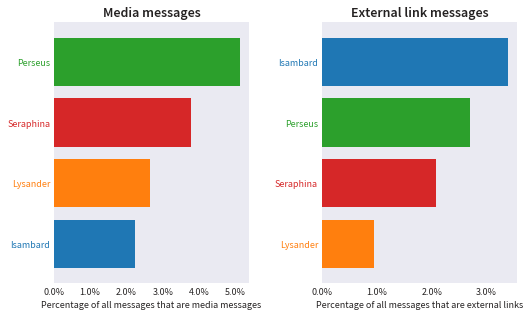

In [15]:
# Message type stats

plt.figure(figsize=[10*.75,6*.75])

# Proportion of messages that are media messages
plt.subplot(1,2,1)
df.groupby('author').is_media_message.mean().pipe(formatted_barh_plot, pct_axis=1)
plt.title('Media messages')
plt.xlabel('Percentage of all messages that are media messages')
plt.ylabel('')

# Proportion of messages that are URL links
plt.subplot(1,2,2)
df.groupby('author').is_link.mean().pipe(formatted_barh_plot, pct_axis=1)
plt.title('External link messages')
plt.xlabel('Percentage of all messages that are external links')
plt.ylabel('')

plt.tight_layout()
plt.savefig(f'{output_dir}/message_types.svg')

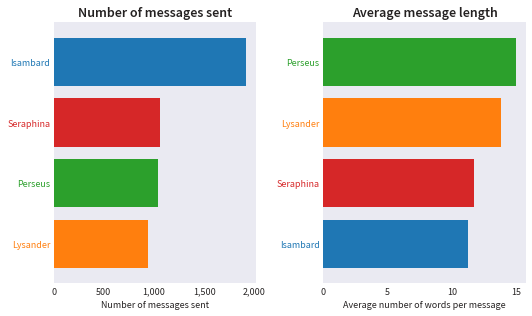

In [16]:
# Total messages sent stats

plt.figure(figsize=[10*.75,6*.75])

# Total messages by user
plt.subplot(1,2,1)
df.groupby('author').size().pipe(formatted_barh_plot, thousands_separator=True)
plt.title('Number of messages sent')
plt.xlabel('Number of messages sent')
plt.ylabel('')

# Average message length by user
plt.subplot(1,2,2)
token_df[(token_df.is_emoji==False) & (token_df.is_punctuation==False)].groupby(['author', 'msg_id']).size().groupby(level=0).mean().pipe(formatted_barh_plot)
plt.title('Average message length')
plt.xlabel('Average number of words per message')
plt.ylabel('')

plt.tight_layout()
plt.savefig(f'{output_dir}/n_messages_and_avg_length.svg')

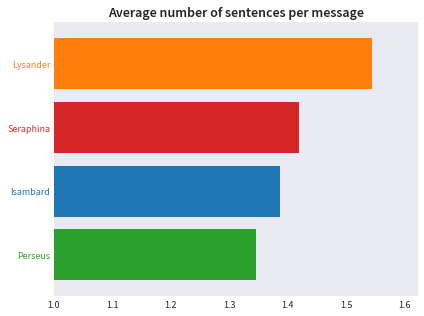

In [17]:
# Number of sentences per message

n_sentences_dict = {}
for author, tdf in df.groupby('author'):
    n_sentences_dict[author] = pd.Series([len(list(msg.sents)) for msg in tdf.parsed_message.dropna()]).mean()
    
pd.Series(n_sentences_dict).pipe(formatted_barh_plot)
plt.xlim(1,plt.xlim()[1])
plt.ylabel('')
plt.title('Average number of sentences per message')
plt.tight_layout()
plt.savefig(f'{output_dir}/sentences_per_message.svg')

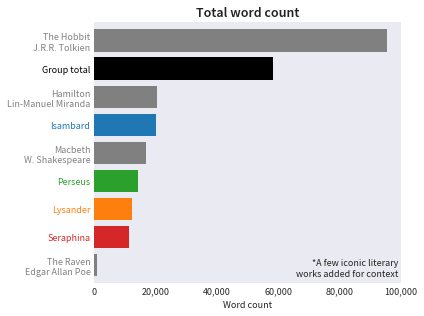

In [18]:
# Word count

# Define the word count of some notable works of literature as a reference
word_count_plot_s = pd.DataFrame([('The Lord of the Rings\nJ.R.R. Tolkien', 455_125),
                                   ("The Hobbit\nJ.R.R. Tolkien", 95_356),
                                   ("Harry potter and the Order of the Phoenix\nJ.K. Rowling", 257_045),
                                   ('7 Harry potter books combined\nJ.K. Rowling', 1_086_625),
                                   ('War and Peace\nL. Tolstoy', 587_287),
                                   ('The Bible', 783_137),
                                   ('Macbeth\nW. Shakespeare', 17_084),
                                   ('The Iliad\nHomer', 148_045),
                                   ('The Raven\nEdgar Allan Poe', 1_140),
                                   ('I Wandered Lonely as a Cloud\nWilliam Wordsworth', 153),
                                   ('Ozymandias\nPercy Shelley', 111),
                                   ('Hamilton\nLin-Manuel Miranda', 20_520),
                                   ('A song of Ice and Fire (First 5 books)\nGeorge R R Martin', 1_770_000),
                                   ('The very hungry caterpillar\nEric Carle', 290)],
                                  columns=['source', 'word_count']).set_index('source').word_count

word_count_s = token_df[(token_df.is_emoji==False) & (token_df.is_punctuation==False)].groupby('author').size()
for n, (author,wc) in enumerate(word_count_s.iteritems()):
    word_count_plot_s.loc[author] = wc
    
word_count_plot_s.loc['Group total'] = word_count_s.sum()
word_count_plot_s.sort_values(inplace=True)

# Define highest and lowest label. Currently set to only show 1 contextual point above and below the relevant data points

try:
    lowest_label = word_count_plot_s.pipe(lambda x:x[x<word_count_s.min()]).tail(1).index[0]
except IndexError:
    lowest_label = word_count_plot_s.index[0]
highest_label = word_count_plot_s.pipe(lambda x:x[x>word_count_s.sum()]).head(1).index[0]

word_count_plot_s.loc[lowest_label:highest_label].pipe(formatted_barh_plot, thousands_separator=True)
plt.title('Total word count')
plt.xlabel('Word count')
plt.gca().text(.99,0.02,'*A few iconic literary\nworks added for context', transform=plt.gca().transAxes, ha='right', va='bottom')
plt.ylabel('')
plt.tight_layout()
plt.savefig(f'{output_dir}/word_counts.svg')

# Timeseries analysis

In [19]:
# Function to create bespoke linear segmented color map.
# Will be useful to create colormaps for each user consistent with their colour scheme

def create_colormap(colors=['w', 'g'], n_bins=256):
    n_bins = 256  # Discretizes the interpolation into bins
    cmap_name = 'temp_cmap'

    # Create the colormap
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return(cm)

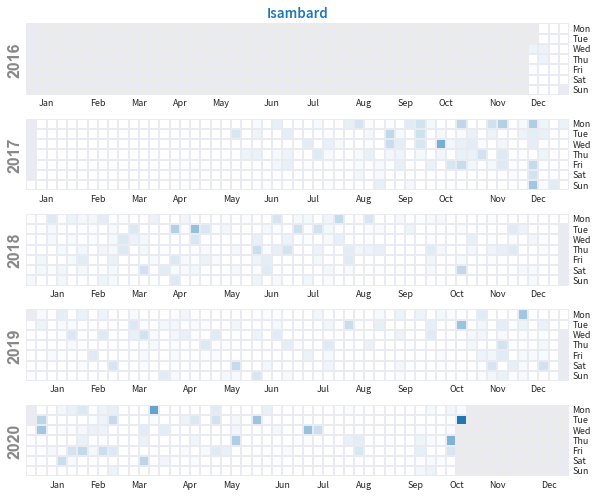

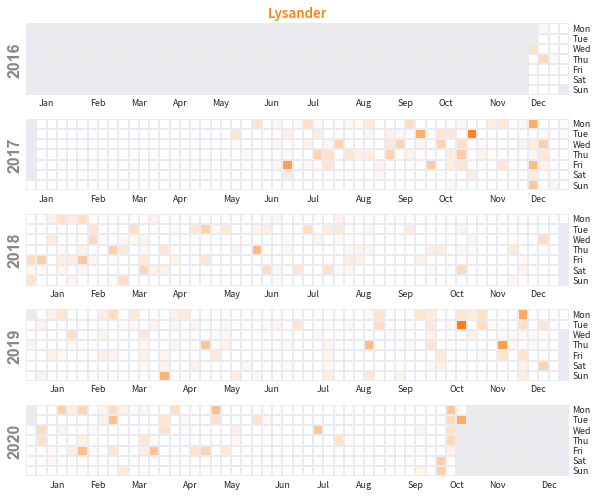

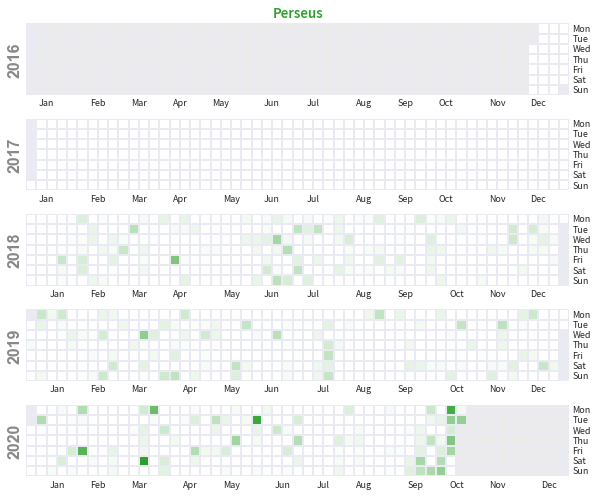

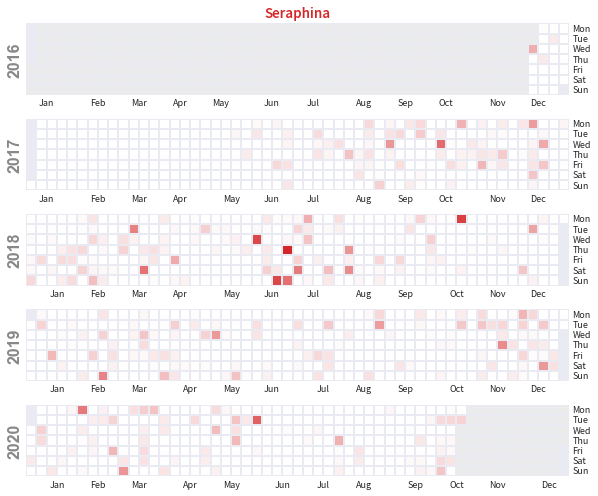

In [20]:
# Calendar view for each user

activity_by_author_and_day = df.groupby(['author', 'timestamp']).first().unstack(level=0).resample('D').sum().msg_length.fillna(0)
for author, author_timeseries in activity_by_author_and_day.iteritems():
    cm=create_colormap(['w',plt.rcParams['axes.prop_cycle'].by_key()['color'][int(author_color_lookup[author][-1])]])
    fig, axes = calmap.calendarplot(author_timeseries,
                                    yearlabel_kws={'color':'#888888', 'size':16},
                                    fillcolor='#EBEBEB',
                                    cmap=cm)
    axes[0].set_title(author, size=15, color=author_color_lookup[author])
    fig.set_size_inches(8.3,7)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/calmap-{author.replace(' ','_')}.svg")

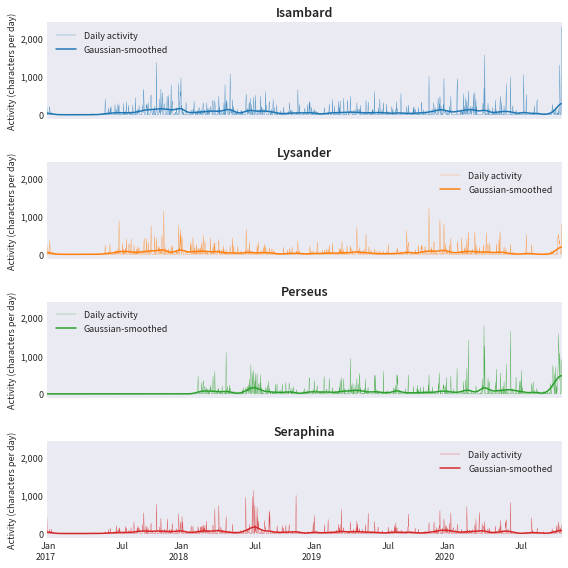

In [21]:
# Overall activity timeseries - subplot per user
daily_activity_df = df.groupby(['author', 'timestamp']).first().unstack(level=0).resample('D').sum().msg_length.fillna(0)
smoothed_daily_activity_df = pd.DataFrame(gaussian_filter(daily_activity_df, (12,0)), 
                                          index=daily_activity_df.index,
                                          columns=daily_activity_df.columns)

ax = daily_activity_df.plot(figsize=[8,2*len(df.author.unique())], subplots=True, sharey=True, lw=0.3, label=None)
subplots = smoothed_daily_activity_df.plot(figsize=[8,2*len(df.author.unique())], subplots=True, ax=ax)
[ax.set_title(auth) for auth, ax in zip(df.groupby('author').size().index, subplots)]
[ax.set_ylabel('Activity (characters per day)') for auth, ax in zip(df.groupby('author').size().index, subplots)]
plt.xlabel('')
#plt.legend(['Daily activity', 'Gaussian-smoothed'])
[ax.legend(['Daily activity', 'Gaussian-smoothed']) for ax in subplots]
[ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ','))) for ax in subplots]
plt.tight_layout()
plt.savefig(f'{output_dir}/activity_timeseries.svg')

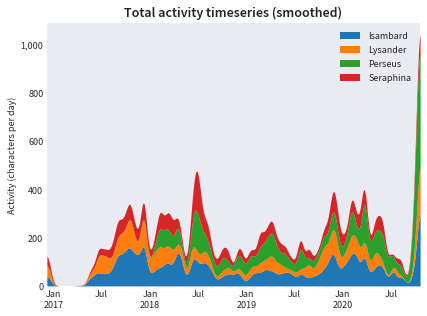

In [22]:
# Smoothed stacked activity area timeseries plot

smoothed_daily_activity_df.plot(kind='area', stacked=True, lw=0)
plt.title('Total activity timeseries (smoothed)')
plt.ylabel('Activity (characters per day)')
plt.xlabel('')
plt.tight_layout()
plt.gca().legend(title=None);
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig(f'{output_dir}/activity_timerseries_stacked_area.svg')

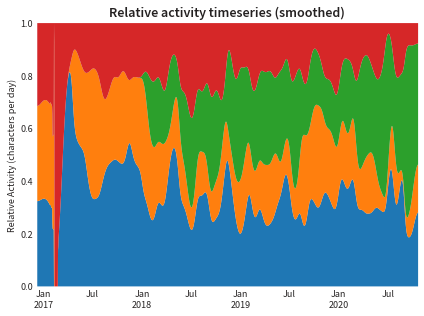

In [23]:
# Relative activity timeseries - 100% stacked area plot
smoothed_daily_activity_df.div(smoothed_daily_activity_df.sum(axis=1), axis=0).plot(kind='area', legend=False, stacked=True, lw=0)
plt.title('Relative activity timeseries (smoothed)')
plt.ylabel('Relative Activity (characters per day)')
plt.xlabel('')
plt.ylim(0,1)
#plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'{output_dir}/relative_activity_timerseries.svg')

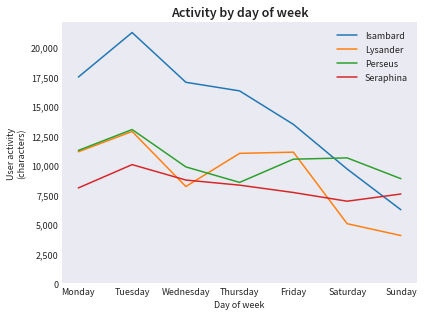

In [24]:
# Timeseries : Activity by day of week
df.groupby([df.timestamp.dt.dayofweek, df.author]).msg_length.sum().unstack().fillna(0).plot()

plt.xlabel('Day of week')
plt.ylabel('User activity\n(characters)')
plt.xticks(range(7),['Monday',
                    'Tuesday',
                    'Wednesday',
                    'Thursday',
                    'Friday',
                    'Saturday',
                    'Sunday'])

plt.ylim(0,plt.ylim()[1])
plt.title('Activity by day of week')
plt.gca().legend(title=None);
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.savefig(f'{output_dir}/activity_by_day_of_week.svg')

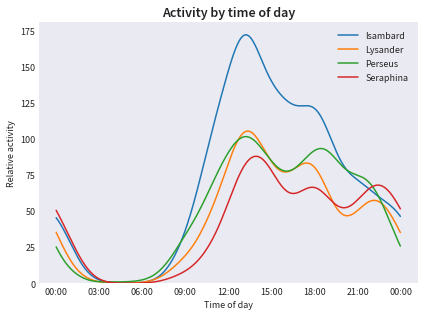

In [25]:
# Timeseries : Activity by time of day

a = df.groupby([df.timestamp.dt.time, df.author]).msg_length.sum().unstack().fillna(0)
a = a.reindex([datetime.time(i, j) for i in range(24) for j in range(60)]).fillna(0)

# Temporarily add the tail at the start and head and the end of the data frame for the gaussian smoothing 
# to be continuous around midnight
a = pd.concat([a.tail(120), a, a.head(120)]) 

# Apply gaussian convolution
b = pd.DataFrame(gaussian_filter(a.values, (60,0)), index=a.index, columns=a.columns)

# Remove the points temporarily added from the ends
b = b.iloc[120:-120]

# Plot the smoothed data
b.plot(ax=plt.gca())

plt.xticks(range(0,24*60*60+1, 3*60*60))
plt.xlabel('Time of day')
plt.ylabel('Relative activity')
plt.ylim(0,plt.ylim()[1])
plt.title('Activity by time of day')
plt.gca().legend(title=None);
plt.tight_layout()
plt.savefig(f'{output_dir}/activity_by_time_of_day.svg')

# Group dyamics

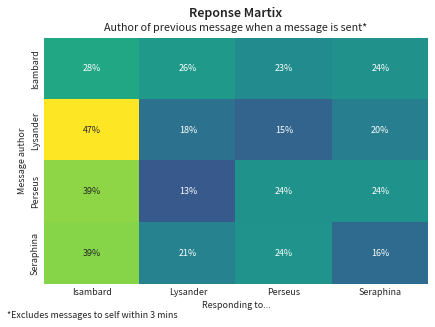

In [26]:
# Response matrix

prev_msg_lt_180_seconds = (df.timestamp - df.timestamp.shift(1)).dt.seconds < 180
same_prev_author = (df.author == df.author.shift(1))

(df
    [~(prev_msg_lt_180_seconds & same_prev_author)]
    .groupby([df.author.rename('Message author'), df.author.shift(1).rename('Responding to...')])
    .size()
    .unstack()
    .pipe(lambda x:x.div(x.sum(axis=1), axis=0))
    .pipe(sns.heatmap, vmin=0, annot=True, fmt='.0%', cmap='viridis', cbar=False))

plt.title('Reponse Martix\n ')
plt.gca().text(.5,1.04,"Author of previous message when a message is sent*", ha='center', va='center', size=12, transform=plt.gca().transAxes);
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), va='center', minor=False)
plt.gcf().text(0,0,"*Excludes messages to self within 3 mins", va='bottom')
plt.tight_layout()
plt.savefig(f'{output_dir}/response_matrix.svg')

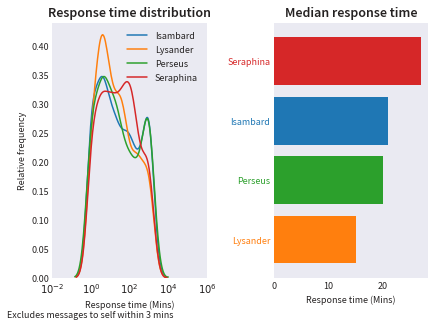

In [27]:
# Response time

plt.subplot(121)
((df.timestamp - df.timestamp.shift(1)).dt.seconds
    .replace(0,np.nan)
    .div(60)
    .apply(np.log10)
    [~(prev_msg_lt_180_seconds & same_prev_author)]
    .groupby(df.author)
    .apply(sns.kdeplot))
plt.title('Response time distribution')
plt.ylabel('Relative frequency')
plt.xlabel('Response time (Mins)')
locs, ticks = plt.xticks()
plt.xticks(locs, [f"$10^{{{int(loc)}}}$" for loc in locs])


plt.subplot(122)
((df.timestamp - df.timestamp.shift(1)).dt.seconds
    .replace(0,np.nan)
    .div(60)
    [~(prev_msg_lt_180_seconds & same_prev_author)]
    .groupby(df.author)
    .median()
    .pipe(formatted_barh_plot))
plt.title('Median response time')
plt.ylabel('')
plt.xlabel('Response time (Mins)')

plt.gcf().text(0,0,"Excludes messages to self within 3 mins", va='bottom')
plt.tight_layout()
plt.savefig(f'{output_dir}/response_time.svg')

# Lexical characterization

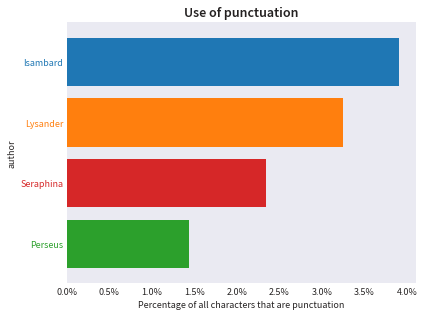

In [28]:
# Use of punctuation

text_message_ids = df[(df.is_link==0) & (df.is_media_message==0)].index.tolist()
(token_df
    [token_df.msg_id.isin(text_message_ids)]
    .text
    .str
    .len()
    .groupby([token_df.author, token_df.is_punctuation])
    .sum()
    .unstack()
    .pipe(lambda x:x[True]/x.sum(axis=1))
    .pipe(formatted_barh_plot, width=0.8, legend=False)
    )

plt.gca().set_xticklabels(['{:0.1f}%'.format(100*x) for x in plt.gca().get_xticks()])
plt.title('Use of punctuation')
plt.xlabel('Percentage of all characters that are punctuation')
plt.tight_layout()
plt.savefig(f'{output_dir}/punctuation_use.svg')

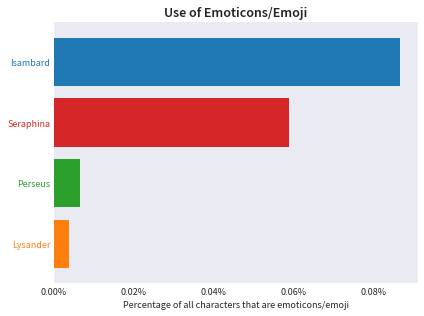

In [29]:
# Use of Emoticons / Emoji

token_df.text.str.len().groupby([token_df.author, token_df.is_emoji==1]).sum().unstack().pipe(lambda x:x[True] / x.sum(axis=1)).pipe(formatted_barh_plot, pct_axis=2)
plt.ylabel('')
plt.title('Use of Emoticons/Emoji')
plt.xlabel('Percentage of all characters that are emoticons/emoji')
plt.tight_layout()
plt.savefig(f'{output_dir}/emoticon_use.svg')

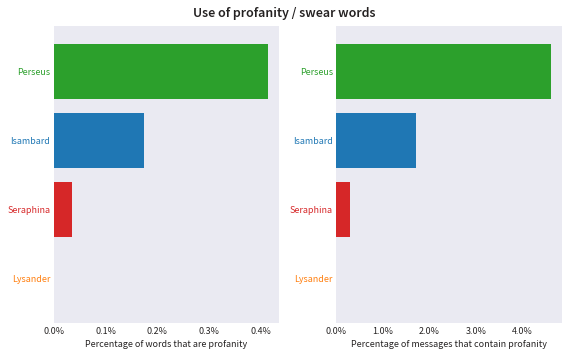

In [30]:
# Use of profanity 

## Uses the profanity-check library (https://github.com/vzhou842/profanity-check) to detect profanity

plt.figure(figsize=[8,5])

plt.subplot(121)
token_df[~token_df.is_emoji & ~token_df.is_punctuation].groupby('author').is_profanity.mean().pipe(formatted_barh_plot, pct_axis=1)
plt.ylabel('')
plt.title(' ')
plt.xlabel('Percentage of words that are profanity')

plt.subplot(122)
df[~(df.is_media_message==1) & ~(df.is_link==1)].groupby('author').contains_profanity.mean().pipe(formatted_barh_plot, pct_axis=1)
plt.ylabel('')
plt.title(' ')
plt.xlabel('Percentage of messages that contain profanity')

plt.suptitle('Use of profanity / swear words')
plt.tight_layout()
plt.savefig(f'{output_dir}/profanity_use.svg')

In [31]:
# Defining function to plot the top words for each user. Accepts a filtered token_df and creates a plot of top words per user

def plot_top_tokens_per_user(token_df):
    token_counts = token_df.groupby([token_df.text.str.lower(), 'author']).size()
    
    fig, axes = plt.subplots(1, df.author.unique().size, figsize=[15,6], gridspec_kw=dict(top=.85, wspace=.5))
    for (name, author_token_df), ax in zip(token_counts.groupby(level=1), axes):
        (author_token_df
             .reset_index(level=1, drop=True)
             .sort_values(ascending=False)
             .head(20)
             .iloc[::-1]
             .plot(kind='barh', color=author_color_lookup[name], ax=ax))
        ax.set_title(name)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('')
        
    fig.suptitle("Characeristic words", size=16)
    fig.text(.5,.94,"Words used disproportionately often relative to word's natural occurrence rate on the web", ha='center', va='top', size=12);


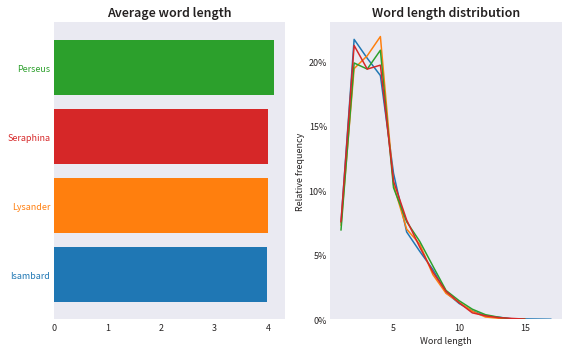

In [32]:
# Plot average word length and word length distribution

plt.figure(figsize=[8,5])

plt.subplot(121)
token_df[(token_df.is_out_of_vocab==False) & (~token_df.part_of_speech.isin(['PUNCT']))].text.str.len().groupby(token_df.author).mean().pipe(formatted_barh_plot)
plt.title('Average word length')
plt.ylabel('')

plt.subplot(122)
token_df[(token_df.is_out_of_vocab==False) & (~token_df.part_of_speech.isin(['PUNCT']))].text.str.len().groupby(token_df.author).apply(lambda x:x.value_counts().div(len(x)).sort_index().plot(legend=False));
plt.title('Word length distribution')
plt.xlabel('Word length')
plt.ylabel('Relative frequency')
plt.ylim(0,plt.ylim()[1])
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))

plt.tight_layout()
plt.savefig(f'{output_dir}/word_length_distribution.svg')

C:\Users\Danny\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


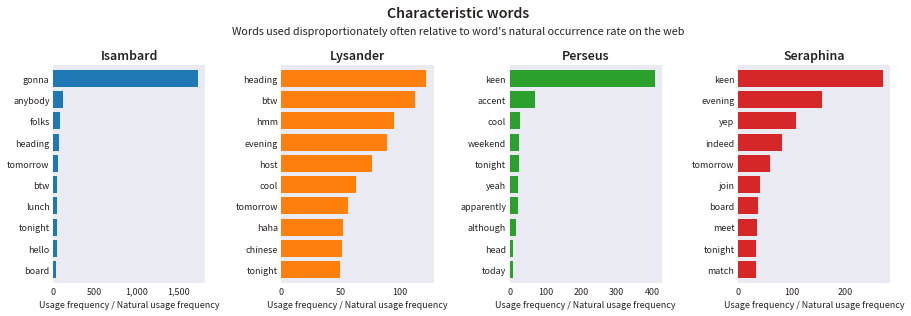

In [33]:
# Words used most disproportionatley often by each person

filter_ = (token_df.is_punctuation == False) & (token_df.is_emoji == False) & (token_df.log_probability >-18) & ~(token_df.part_of_speech.isin(['PROPN', 'SPACE'])) & (token_df.text.str.len() > 2)
token_use_summary_df = token_df[filter_].groupby([token_df[filter_].author, token_df[filter_].text.str.lower().replace('gon', 'gonna')]).log_probability.agg(['size', 'mean'])
token_use_summary_df['usage_freq'] = token_use_summary_df['size'] / token_use_summary_df['size'].groupby(level=0).sum()
token_use_summary_df['log_usage_freq'] = token_use_summary_df['usage_freq'].apply(np.log)

a = (token_use_summary_df['log_usage_freq'] - token_use_summary_df['mean'])[(token_use_summary_df['size'] > 10)].sort_values(ascending=False).groupby(level=0).head(10)

fig, axes = plt.subplots(1, df.author.unique().size, figsize=[15,4.5], gridspec_kw=dict(top=.80, wspace=.5))
for (name, author_token_df), ax in zip(a.groupby(level=0), axes):
    (author_token_df
         .reset_index(level=0, drop=True)
         .sort_values(ascending=False)
         .head(20)
         .iloc[::-1]
         .apply(np.exp)
         .plot(kind='barh', width=.8, color=author_color_lookup[name], ax=ax))
    ax.set_title(name)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('')
    ax.set_xlabel("Usage frequency / Natural usage frequency")
    ax.set_ylabel('')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
fig.suptitle("Characteristic words", size=16)
fig.text(.5,.92,"Words used disproportionately often relative to word's natural occurrence rate on the web", ha='center', va='top', size=12);
plt.tight_layout()
plt.savefig(f'{output_dir}/characteristic_words.svg')

In [34]:
# Plot of the top profanity words used by each person
#plot_top_tokens_per_user(token_df[(token_df.is_profanity==1)])
#plt.tight_layout()

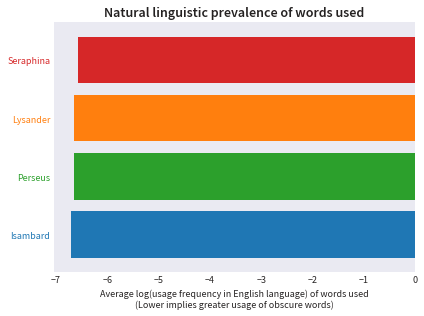

In [35]:
# Average log(natural usage frequency) plot for the words used by each person

token_df[(token_df.log_probability>-18) & ~(token_df.part_of_speech.isin(['PUNCT', 'PROPN', 'NOUN', 'X', 'NUM', 'CCONJ'])) & (~token_df.is_emoji) & (~token_df.is_out_of_vocab)].sort_values('log_probability').groupby('author').log_probability.mean().pipe(formatted_barh_plot)
plt.xlabel('Average log(usage frequency in English language) of words used\n(Lower implies greater usage of obscure words)')
plt.title('Natural linguistic prevalence of words used')
plt.ylabel('');
plt.tight_layout()
plt.savefig(f'{output_dir}/avg_word_prevalence.svg')

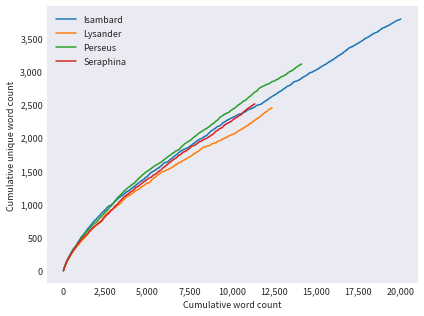

In [36]:
# Vocabulary depth plot

filter_ = (token_df.is_punctuation == False) & (token_df.is_emoji == False) & ~(token_df.part_of_speech.isin(['SPACE'])) & (token_df.is_out_of_vocab == False)
for author_name, author_df in token_df[filter_].groupby('author'):
    unique_word_id = pd.Series(author_df.text.unique()).to_frame().reset_index().rename(columns={0:'word', 'index':'word_id'}).set_index('word').word_id
    author_df.reset_index().text.map(unique_word_id).expanding().max().plot(label=author_name, legend=True, color=author_color_lookup[author_name])

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('Cumulative word count')
plt.ylabel('Cumulative unique word count')
plt.tight_layout()
plt.savefig(f'{output_dir}/word_count_curves.svg')

These curves provide an indication of the breadth in each user's vocabulary. Steeper curves are indicative of a broader vocabulary

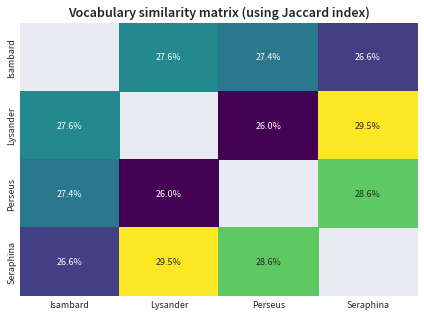

In [37]:
# Linguistic similarity (using Jaccard similary score)

bag_of_words_df = token_df.groupby([token_df.text.str.lower(), 'author']).size().gt(0).unstack().fillna(False)
a = pd.DataFrame(1 - pairwise_distances(bag_of_words_df.T, metric="jaccard"),
                 index=bag_of_words_df.columns,
                 columns=bag_of_words_df.columns)
sns.heatmap(a.replace(1,np.nan), annot=True, fmt='.1%', cmap='viridis', cbar=False)
plt.title('Vocabulary similarity matrix (using Jaccard index)')
plt.xlabel('')
plt.ylabel('')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), va='center', minor=False)
plt.tight_layout()
plt.savefig(f'{output_dir}/vocabulary_similarity_matrix.svg')